In [1]:
import os
import json
import glob

from matplotlib import pyplot as plt
from matplotlib import markers

from collections import OrderedDict

from configs import load

import numpy as np

import pandas as pd

In [3]:
# "../subjects/ismrm_basic/predicted_fibers/2019-11-22-*"

results=[]
temp=[]
for file in glob.glob("../subjects/ismrm_basic/predicted_fibers/2019-11-28-*"):    
    config_path = os.path.join(file, "config.yml")
    temp.append(load(config_path)["model_path"].split("T=")[1][:6])
    
models = glob.glob("../models/Entrack/conditional/2019-11-13/22:24:08/model_T=*.h5")
T = [m.split("_T=")[1].split(".h")[0] for m in models]

# set(T) - set(temp)

In [2]:
def plot_score(results, temp, score_name):
    
    scores = [r[score_name] for r in results]
    
    plt.plot(temp, scores, "-o")
    plt.ylabel(score_name)
    plt.xlabel("T")
    plt.xticks(rotation=90)

In [3]:
def plot_OR_OL(results, temp):
    
    OL = [r["mean_OL"] for r in results]
    OR = [r["mean_OR"] for r in results]
    
    color = [plt.get_cmap("brg")(0.5*i/len(temp)) for i in range(len(temp))]

    plt.scatter(OL, OR, c=color)
    plt.xlabel("OL")
    plt.ylabel("OR")
    

In [4]:
# 2019-11-22-16:24:07 to 2019-11-22-19:32:18, pred_fn = sample
# 2019-11-22-21:04:43 to 2019-11-22-23:14:19, pred_fn = mean
# "../subjects/ismrm_basic/predicted_fibers/2019-11-28-*" MITK11 model

def get_results(dir_glob):
    results=[]
    temp=[]
    for directory in glob.glob(dir_glob):

        timestamp = directory.split("/")[-1]
        result_path = os.path.join(directory, "scorings", "scores", timestamp + ".json")

        if os.path.exists(result_path):
            config_path = os.path.join(directory, "config.yml")
            config = load(config_path)
            temp.append(float(config["model_path"].split("T=")[1][:6]))
            with open(result_path) as json_file:
                results.append(json.load(json_file))

    order = np.argsort(temp)
    temp = [temp[i] for i in order]
    results = [results[i] for i in order]
    
    return temp, results

In [5]:
def get_runs(*dir_globs):
    
    T = []
    R = []
    
    for dir_glob in dir_globs:
        t, r = get_results(dir_glob)
        T.append(t)
        R.append(r)
        
    return T, R

In [6]:
def average_runs(*dir_globs, metric):
    
    T, R = get_runs(*dir_globs)
    
    Tsets = []
    for t in T:
        Tsets.append(set(t))
    
    common_T = set()
    for tset in Tsets:
        common_T = common_T.union(tset)
    
    common_T = list(common_T)
    common_T.sort()
    
    metric_means = []
    for t in common_T:
        metric_values = []
        for i, r in enumerate(R):
            if t in T[i]:
                metric_values.append(r[T[i].index(t)][metric])
        metric_means.append(np.mean(metric_values))
    
    return common_T, metric_means

In [16]:
uniT = 0.00842336 # T15

In [27]:
def plot_average(*dir_globs, metric="VC"):
    
    common_T, metric_means = average_runs(*dir_globs, metric=metric)
    
    common_T = np.array(common_T)
    metric_means = pd.DataFrame(metric_means).rolling(window=4).mean().values.reshape(-1)
    
    plt.plot(1/(common_T / uniT), metric_means, "-o", label=metric)
    plt.ylabel("Score", fontdict={"size": 12})
    plt.xlabel(r"$\beta/\beta_{15^\circ}$", fontdict={"size": 12})
    plt.xticks(rotation=90)

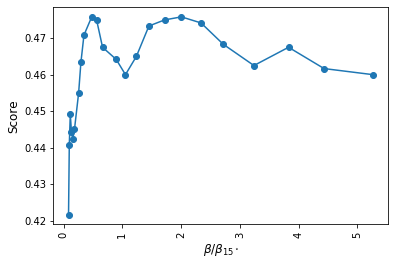

In [54]:
plot_average("../subjects/ismrm_basic/predicted_fibers/2019-12-02-*", metric="IB")

# TM Plot

In [158]:
def plot_average(*dir_globs, metric="VC"):
    
    common_T, metric_means = average_runs(*dir_globs, metric=metric)
    
    metric_means = np.array(metric_means)
    
    if metric in ["VC", "mean_F1", "VB"]:
        idx = np.argmax(metric_means)
    else:
        idx = np.argmin(metric_means)
    
    opt = metric_means[idx]
    
    print(metric, metric_means[idx], 1/(common_T[idx]/uniT))

    metric_means = pd.DataFrame(metric_means).rolling(window=4).mean().values.reshape(-1)
    
    common_T = np.array([1/(t/uniT) for t in common_T])
    
    order = np.argwhere(common_T)
    
    """
    if metric == "IB":
        metric_means /= 300
        
    if metric == "VB":
        metric_means /= 50
    
    if metric == "VB":
        label = metric + r" $(50^{-1})$"
        
    elif metric == "IB":
        label = metric + r" $(300^{-1})$"
        
    else:
        label=metric
    """
    #
    
    metric_means /= np.nanmax(metric_means)
    
    metric_means = metric_means[11:]
    common_T = common_T[11:]
    
    if metric in ["VC", "mean_F1"]:
        label= metric + " ({:1.2f})" if metric != "mean_F1" else "F1 ({:1.2f})"
    elif metric in ["IB", "VB"]:
        label= metric + " ({:3.0f})"
    
    plt.plot(common_T, metric_means, "--x", label=label.format(opt), linewidth=0.75)
    plt.ylabel(r"$S/S_{max}$", fontdict={"size": 12})
    plt.xlabel(r"$\beta/\beta_{15^\circ}$", fontdict={"size": 12})
    plt.xticks(rotation=90)

VB 24.0 8.423359999999999
mean_F1 0.5418613715224706 0.53651974522293
IB 123.0 1.0027809523809523
VC 0.5219742953050995 3.6623304347826084


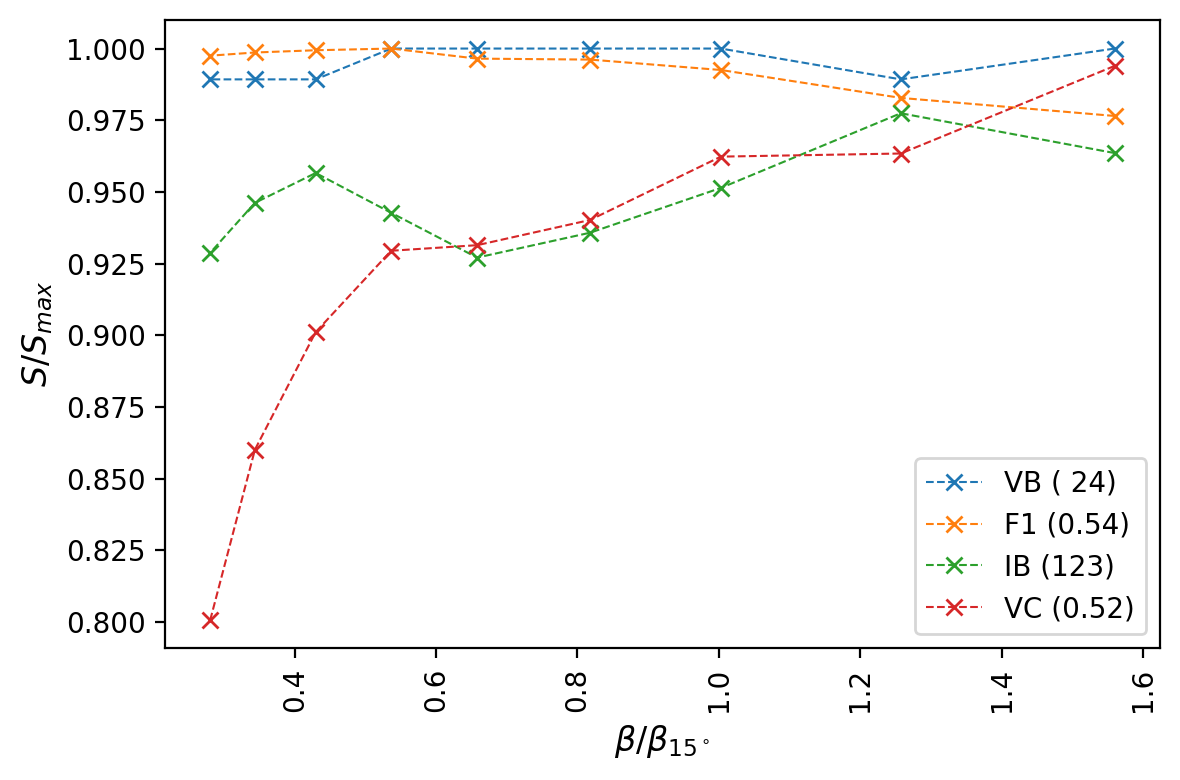

In [161]:
# Sampled scores
plt.figure(dpi=200)


plot_average(
    "../subjects/ismrm_basic/predicted_fibers/2019-11-22-1*",
    metric="VB"
)
plot_average(
    "../subjects/ismrm_basic/predicted_fibers/2019-11-22-1*",
    metric="mean_F1"
)
plot_average(
    "../subjects/ismrm_basic/predicted_fibers/2019-11-22-1*",
    metric="IB"
)
plot_average(
    "../subjects/ismrm_basic/predicted_fibers/2019-11-22-1*",
    metric="VC"
)

plt.legend()
#plt.ylim(0.92,1.005)
plt.tight_layout()
plt.savefig("tm_scores_t.png", bbox_inches=0)

VB 24.0 8.423359999999999
mean_F1 0.5418613715224706 0.53651974522293
IB 123.0 1.0027809523809523
VC 0.5219742953050995 3.6623304347826084


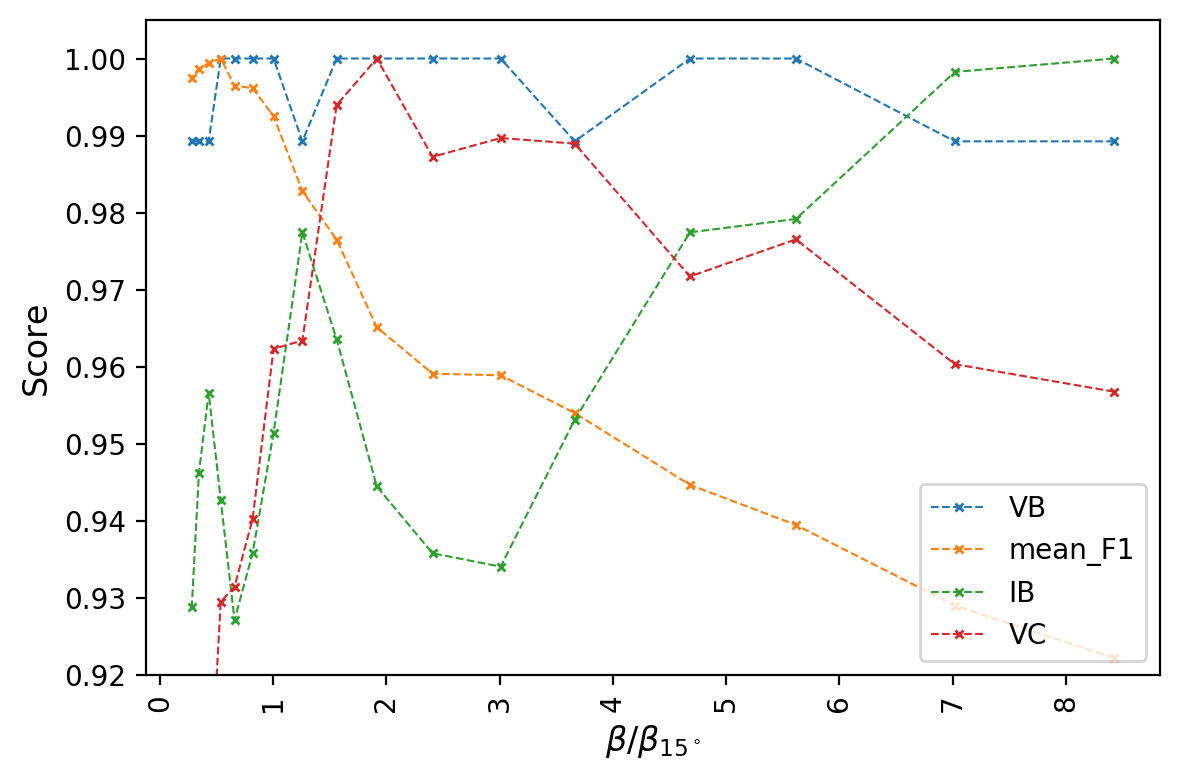

In [116]:
# Sampled scores
plt.figure(dpi=200)


plot_average(
    "../subjects/ismrm_basic/predicted_fibers/2019-11-22-1*",
    metric="VB"
)
plot_average(
    "../subjects/ismrm_basic/predicted_fibers/2019-11-22-1*",
    metric="mean_F1"
)
plot_average(
    "../subjects/ismrm_basic/predicted_fibers/2019-11-22-1*",
    metric="IB"
)
plot_average(
    "../subjects/ismrm_basic/predicted_fibers/2019-11-22-1*",
    metric="VC"
)

plt.legend()
plt.ylim(0.92,1.005)
plt.tight_layout()
plt.savefig("tm_scores_full.png", bbox_inches=0)

VC 0.5480846733855063
mean_F1 0.49606505911379306
IB 146.0
VB 24.0


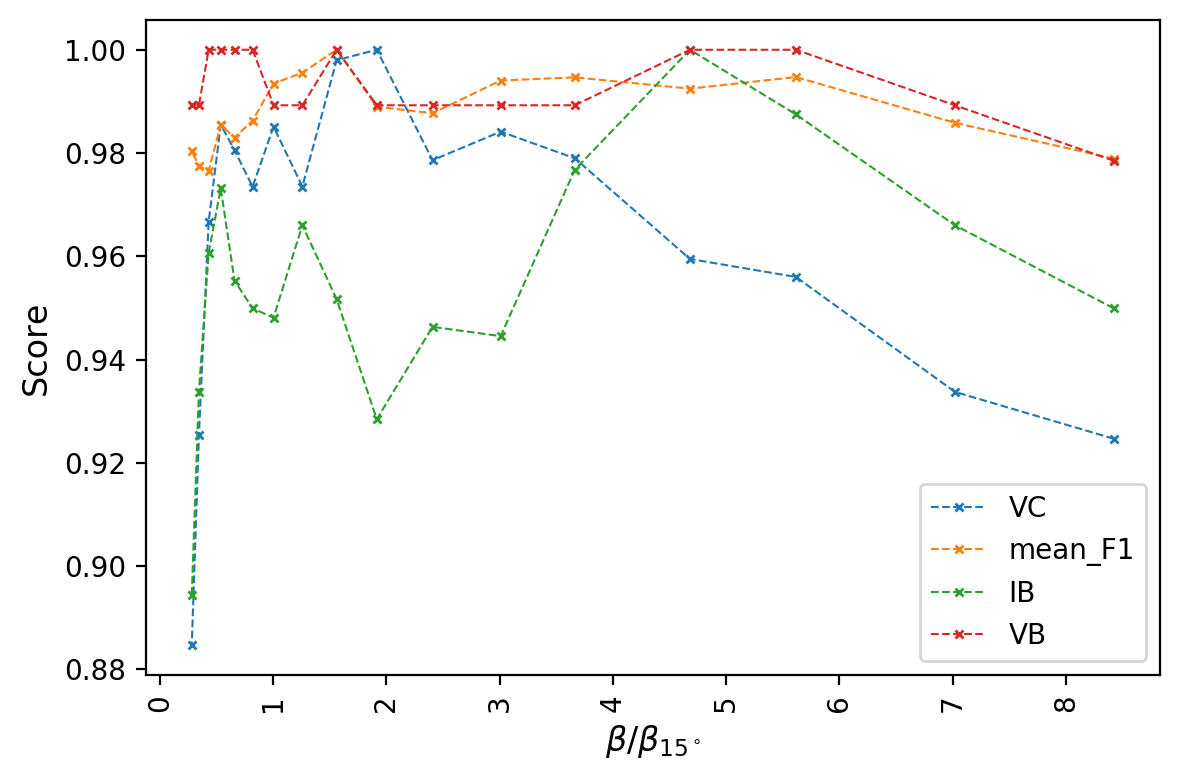

In [112]:
# Sampled scores
plt.figure(dpi=200)


plot_average(
    "../subjects/ismrm_basic/predicted_fibers/2019-11-22-2*",
    metric="VC"
)
plot_average(
    "../subjects/ismrm_basic/predicted_fibers/2019-11-22-2*",
    metric="mean_F1"
)
plot_average(
    "../subjects/ismrm_basic/predicted_fibers/2019-11-22-2*",
    metric="IB"
)
plot_average(
    "../subjects/ismrm_basic/predicted_fibers/2019-11-22-2*",
    metric="VB"
)

plt.legend()
#plt.xlim(0.2,2)
plt.tight_layout()
#plt.savefig("tm_scores_low_beta.png", bbox_inches=0)

(0.48, 0.52)

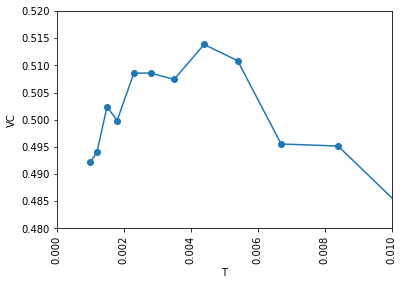

In [61]:
plot_average(
    "../subjects/ismrm_basic/predicted_fibers/2019-11-22-1*",
    "../subjects/ismrm_basic/predicted_fibers/2019-11-23-*",
    metric="VC"
)
plt.xlim(0,0.01)
plt.ylim(0.48,0.52)

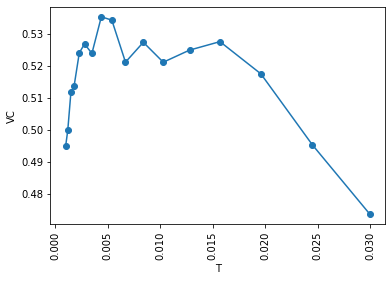

In [50]:
plot_average(
    "../subjects/ismrm_basic/predicted_fibers/2019-11-22-2*",
    metric="VC"
)

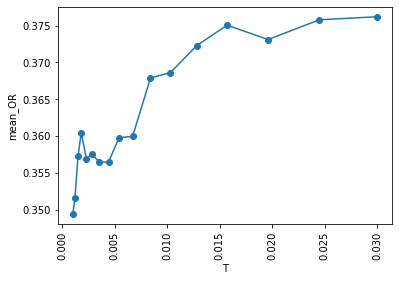

In [39]:
plot_average(
    "../subjects/ismrm_basic/predicted_fibers/2019-11-22-1*",
    "../subjects/ismrm_basic/predicted_fibers/2019-11-23-*",
    metric="mean_OR"
)

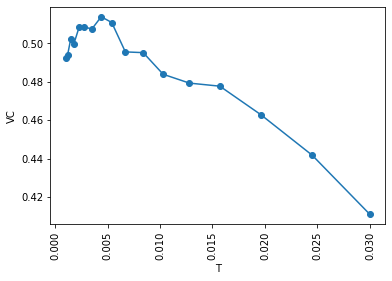

In [44]:
plot_average(
    "../subjects/ismrm_basic/predicted_fibers/2019-11-22-1*",
    "../subjects/ismrm_basic/predicted_fibers/2019-11-23-*",
    metric="VC"
)

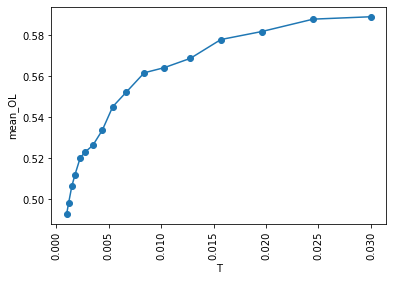

In [45]:
plot_average(
    "../subjects/ismrm_basic/predicted_fibers/2019-11-22-1*",
    "../subjects/ismrm_basic/predicted_fibers/2019-11-23-*",
    metric="mean_OL"
)

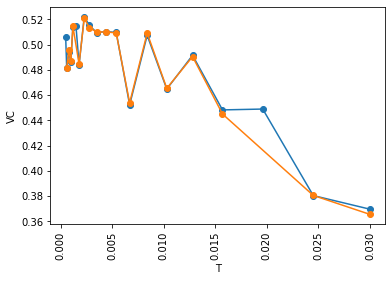

In [101]:
plot_average(
    "../subjects/ismrm_basic/predicted_fibers/2019-11-22-1*",
    metric="VC"
)
plot_average(
    "../subjects/ismrm_basic/predicted_fibers/2019-11-23-*",
    metric="VC"
)

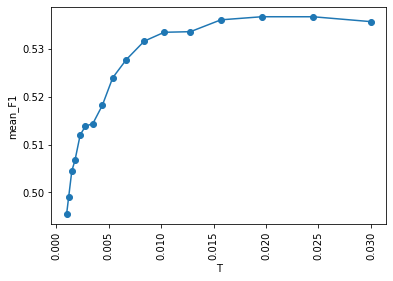

In [46]:
plot_average(
    "../subjects/ismrm_basic/predicted_fibers/2019-11-22-1*",
    "../subjects/ismrm_basic/predicted_fibers/2019-11-23-*",
    metric="mean_F1"
)

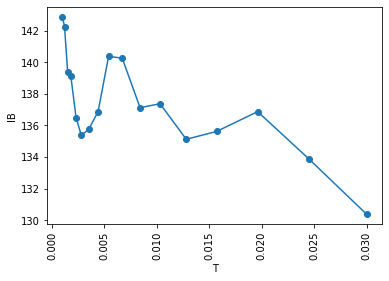

In [47]:
plot_average(
    "../subjects/ismrm_basic/predicted_fibers/2019-11-22-1*",
    "../subjects/ismrm_basic/predicted_fibers/2019-11-23-*",
    metric="IB"
)

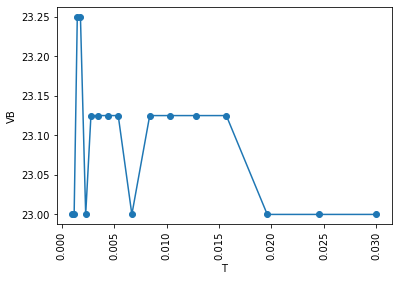

In [48]:
plot_average(
    "../subjects/ismrm_basic/predicted_fibers/2019-11-22-1*",
    "../subjects/ismrm_basic/predicted_fibers/2019-11-23-*",
    metric="VB"
)

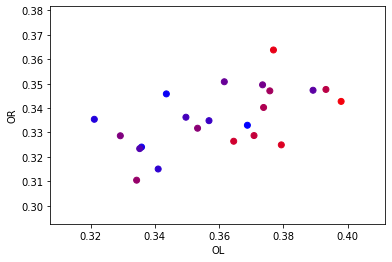

In [49]:
plot_OR_OL(results, temp)

In [162]:
from scipy.stats import hmean

In [166]:
hmean([0.53, 1-0.36])

0.5798290598290599